In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import joblib
import importlib
from scipy import sparse
import implicit

# Add src directory to python path
sys.path.append(os.path.abspath("src"))

import cbf
from cbf import score_cbf_last_item_candidates
from metrics import eval_hr_ndcg

## Config

In [4]:
DATA_PROCESSED = Path("data/processed")

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

# 1. Load Data

In [5]:
# Load preprocessed interaction data
print("Loading interactions...")
train_df = pd.read_parquet(DATA_PROCESSED / "interactions_train.parquet")
val_df = pd.read_parquet(DATA_PROCESSED / "interactions_val.parquet")
test_df = pd.read_parquet(DATA_PROCESSED / "interactions_test.parquet")

print("Train/Val/Test shapes:", train_df.shape, val_df.shape, test_df.shape)
train_df.head()

Loading interactions...
Train/Val/Test shapes: (59659, 8) (794, 8) (814, 8)


,visitorid,itemid,ts_last,w_sum,w_max,n_events,u,i
0,3465,8523,2015-06-16 01:34:15.600000+00:00,4.0,3.0,2,0,437
1,3926,36039,2015-06-17 00:33:53.859000+00:00,2.0,1.0,2,1,1917
2,3926,335331,2015-06-02 20:01:56.963000+00:00,12.0,10.0,3,1,18298
3,4101,104752,2015-05-21 00:32:25.232000+00:00,14.0,10.0,3,2,5729
4,4101,115244,2015-05-21 00:25:10.185000+00:00,2.0,1.0,2,2,6288


# 2. Load Mappings & Matrices

In [6]:
# Load ID mappings and sparse matrices
print("Loading mappings and matrices...")
with open(DATA_PROCESSED / "user2idx.json", "r") as f:
    user2idx = json.load(f)
    # Convert JSON string keys to integers
    user2idx = {int(k): v for k, v in user2idx.items()}

with open(DATA_PROCESSED / "item2idx.json", "r") as f:
    item2idx = json.load(f)
    item2idx = {int(k): v for k, v in item2idx.items()}

n_users = len(user2idx)
n_items = len(item2idx)

print(f"Total Users: {n_users}, Total Items: {n_items}")

X_train = sparse.load_npz(DATA_PROCESSED / "X_train_csr.npz")
print("X_train sparsity:", X_train.nnz / (n_users * n_items))

Loading mappings and matrices...
Total Users: 984, Total Items: 25479
X_train sparsity: 0.0023795700396660154


In [7]:
# Load TF-IDF features
print("Loading TF-IDF matrix...")
X_tfidf = sparse.load_npz(DATA_PROCESSED / "item_content_tfidf.npz")
vectorizer = joblib.load(DATA_PROCESSED / "tfidf_vectorizer.joblib")

print("X_tfidf shape:", X_tfidf.shape)

Loading TF-IDF matrix...
X_tfidf shape: (25479, 20122)


## 3. Models

### 3.1 Popularity Model

In [8]:
# Define Popularity model
print("Loading item popularity...")
item_pop = pd.read_parquet(DATA_PROCESSED / "item_popularity.parquet")

pop_vec = np.zeros(n_items, dtype=np.float32)
pop_vec[item_pop["i"]] = item_pop["pop"]

def score_popularity_candidates(candidates):
    return pop_vec[candidates]

Loading item popularity...


### 3.2 Collaborative Filtering (CF)

In [9]:
# Define Collaborative Filtering model
model_cf = implicit.bpr.BayesianPersonalizedRanking(
    factors=64,
    iterations=50,
    learning_rate=0.05,
    random_state=RANDOM_SEED,
)
model_cf.fit(X_train)  # Fit model on training matrix

def score_cf_candidates(batch_u, candidates):
    u_factors = model_cf.user_factors[batch_u] # (batch, 64)
    cand_factors = model_cf.item_factors[candidates] # (batch, 101, 64)
    return np.einsum("bf,bcf->bc", u_factors, cand_factors)

100%|██████████| 50/50 [00:00<00:00, 204.08it/s, train_auc=99.93%, skipped=7.52%]


### 3.3 Content-Based Filtering (CBF)

In [10]:
# Define Content-Based Filtering model
def score_cbf_candidates(batch_u, candidates, user_history_map):
    last_item_indices = []
    for u in batch_u:
        hist = user_history_map.get(u, [])
        if hist:
            last_item_indices.append(hist[-1])
        else:
            last_item_indices.append(-1)
    last_item_indices = np.array(last_item_indices, dtype=np.int32)
    return score_cbf_last_item_candidates(last_item_indices, candidates, X_tfidf)

### 3.4 Hybrid Ensemble

In [11]:
# Define Hybrid Ensemble model
def normalize_rows(x):
    min_vals = x.min(axis=1, keepdims=True)
    max_vals = x.max(axis=1, keepdims=True)
    # Avoid division by zero
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1.0
    return (x - min_vals) / range_vals

def score_hybrid_candidates(s_cf, s_cbf, cf_weight=0.3, cbf_weight=0.7):
    s_cf_norm = normalize_rows(s_cf)
    s_cbf_norm = normalize_rows(s_cbf)
    return cf_weight * s_cf_norm + cbf_weight * s_cbf_norm

--- Tuning Hybrid Weights on val ---


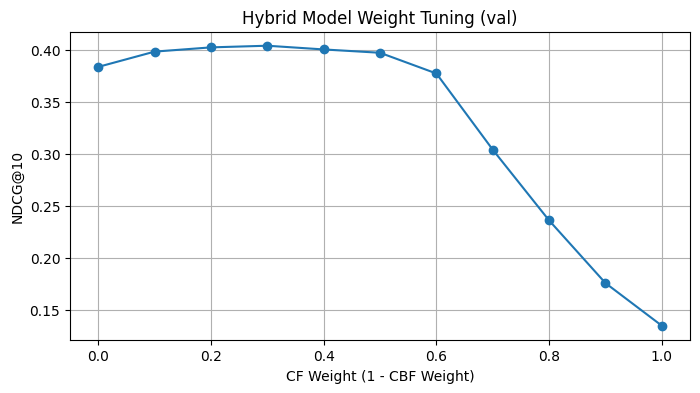

Best Configuration: CF=0.3, CBF=0.7 -> NDCG@10=0.4042


In [12]:
def tune_hybrid_weights(split_name="val"):
    print(f"--- Tuning Hybrid Weights on {split_name} ---")
    
    # Load candidates
    candidates_df = pd.read_parquet(DATA_PROCESSED / f"eval_candidates_{split_name}.parquet")
    
    # Build history map
    if split_name == "val":
        hist_df = train_df
    else:
        hist_df = pd.concat([train_df, val_df])
    user_history_map = hist_df.sort_values("ts_last").groupby("u")["i"].apply(list).to_dict()
    
    n_users = len(candidates_df)
    batch_size = 100
    
    # Store all scores to avoid re-computing
    all_cf_scores = []
    all_cbf_scores = []
    
    # Pre-compute scores
    for start in range(0, n_users, batch_size):
        end = min(start + batch_size, n_users)
        batch_df = candidates_df.iloc[start:end]
        
        batch_u = batch_df["u"].values
        batch_pos = batch_df["pos_i"].values
        batch_negs = np.stack(batch_df["neg_i"].values)
        candidates = np.column_stack([batch_pos, batch_negs])
        
        s_cf = score_cf_candidates(batch_u, candidates)
        s_cbf = score_cbf_candidates(batch_u, candidates, user_history_map)
        
        # Normalize immediately
        all_cf_scores.append(normalize_rows(s_cf))
        all_cbf_scores.append(normalize_rows(s_cbf))
        
    all_cf_scores = np.vstack(all_cf_scores)
    all_cbf_scores = np.vstack(all_cbf_scores)
    
    # Grid Search
    results = []
    weights = np.linspace(0.0, 1.0, 11) # 0.0, 0.1, ... 1.0
    
    for w_cf in weights:
        w_cbf = 1.0 - w_cf
        
        # Vectorized combination
        s_hybrid = w_cf * all_cf_scores + w_cbf * all_cbf_scores
        
        # Fast evaluation (NDCG@10 only)
        metrics = eval_hr_ndcg(s_hybrid, ks=(10,), pos_col=0, rng=rng)
        results.append({"w_cf": w_cf, "w_cbf": w_cbf, "NDCG@10": metrics["NDCG@10"]})
        
    res_df = pd.DataFrame(results)
    
    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(res_df["w_cf"], res_df["NDCG@10"], marker="o")
    plt.xlabel("CF Weight (1 - CBF Weight)")
    plt.ylabel("NDCG@10")
    plt.title(f"Hybrid Model Weight Tuning ({split_name})")
    plt.grid(True)
    plt.show()
    
    best_row = res_df.loc[res_df["NDCG@10"].idxmax()]
    print(f"Best Configuration: CF={best_row['w_cf']:.1f}, CBF={best_row['w_cbf']:.1f} -> NDCG@10={best_row['NDCG@10']:.4f}")
    return res_df


# Run tuning
tuning_results = tune_hybrid_weights("val")

# Extract best weights
best_idx = tuning_results["NDCG@10"].idxmax()
best_cf_w = tuning_results.loc[best_idx, "w_cf"]
best_cbf_w = tuning_results.loc[best_idx, "w_cbf"]

### Model Sanity Check
This function allows us to inspect a single user's predictions to verify model behavior. It compares the ground truth item against recommendations and breaks down the scores (CF vs CBF) to help debug ranking issues.

In [13]:
def inspect_user_predictions(u_id, split_name="val", cf_w=0.3, cbf_w=0.7):
    print(f"--- Inspecting User {u_id} ({split_name}) ---")
    
    # 1. Get History
    if split_name == "val":
        hist_df = train_df
    else:
        hist_df = pd.concat([train_df, val_df])
    
    user_hist = hist_df[hist_df["u"] == u_id].sort_values("ts_last")
    last_item_idx = user_hist["i"].iloc[-1] if len(user_hist) > 0 else -1
    print(f"Last Interaction Item Index: {last_item_idx}")
    
    # 2. Get Target
    candidates_df = pd.read_parquet(DATA_PROCESSED / f"eval_candidates_{split_name}.parquet")
    user_row = candidates_df[candidates_df["u"] == u_id].iloc[0]
    target_item = user_row["pos_i"]
    print(f"Target (Ground Truth) Item Index: {target_item}")
    
    # 3. Score Candidates (Target + 100 Negatives)
    candidates = np.concatenate(([target_item], user_row["neg_i"]))
    
    # Reshape to (1, 101) for the scoring function
    candidates_batch = candidates.reshape(1, -1)
    
    # CF Score
    cf_score = score_cf_candidates(np.array([u_id]), candidates_batch).flatten()
    
    # CBF Score
    # Note: We need to pass the map, but for single user we can just construct the last item list directly
    cbf_score = score_cbf_last_item_candidates(np.array([last_item_idx]), candidates_batch, X_tfidf).flatten()
    
    # Hybrid
    hybrid_score = score_hybrid_candidates(cf_score.reshape(1, -1), cbf_score.reshape(1, -1), cf_weight=cf_w, cbf_weight=cbf_w).flatten()
    
    # 4. Rank and Display
    # Sort by hybrid score descending
    top_indices = np.argsort(-hybrid_score)[:5]
    
    print("\nTop 5 Recommendations (Sorted by Hybrid Score):")
    for rank, idx in enumerate(top_indices):
        item_idx = candidates[idx]
        is_target = "HIT" if item_idx == target_item else ""
        print(f"#{rank+1}: Item {item_idx} | Hybrid Score: {hybrid_score[idx]:.4f} (Raw CF:{cf_score[idx]:.2f}, Raw CBF:{cbf_score[idx]:.2f}) {is_target}")

# Inspect a random user from validation
sample_user = val_df["u"].iloc[0]
print(f"Inspecting with weights: CF={best_cf_w:.2f}, CBF={best_cbf_w:.2f}")
inspect_user_predictions(sample_user, "val", cf_w=best_cf_w, cbf_w=best_cbf_w)

Inspecting with weights: CF=0.30, CBF=0.70
--- Inspecting User 0 (val) ---
Last Interaction Item Index: 437
Target (Ground Truth) Item Index: 6248

Top 5 Recommendations (Sorted by Hybrid Score):
#1: Item 25433 | Hybrid Score: 0.8478 (Raw CF:0.75, Raw CBF:0.40) 
#2: Item 24171 | Hybrid Score: 0.7825 (Raw CF:-0.12, Raw CBF:0.41) 
#3: Item 25012 | Hybrid Score: 0.7517 (Raw CF:0.50, Raw CBF:0.36) 
#4: Item 6368 | Hybrid Score: 0.6194 (Raw CF:0.12, Raw CBF:0.30) 
#5: Item 12770 | Hybrid Score: 0.3849 (Raw CF:1.36, Raw CBF:0.08) 


## 4. Evaluation Loop

In [14]:
def run_paper_protocol_eval(split_name, cf_w=0.3, cbf_w=0.7):
    print(f"--- Evaluating {split_name} split ---")
    
    # Load candidates
    candidates_df = pd.read_parquet(DATA_PROCESSED / f"eval_candidates_{split_name}.parquet")
    
    # Build history map for CBF
    if split_name == "val":
        hist_df = train_df
    else:
        hist_df = pd.concat([train_df, val_df])
        
    user_history_map = hist_df.sort_values("ts_last").groupby("u")["i"].apply(list).to_dict()
    
    n_users = len(candidates_df)
    batch_size = 100
    
    # Initialize metrics
    metric_names = ["HR@5", "NDCG@5", "HR@10", "NDCG@10", "MRR"]
    metric_sums = {
        "Popularity": {m: 0.0 for m in metric_names},
        "CF_BPR": {m: 0.0 for m in metric_names},
        "CBF_LastItem": {m: 0.0 for m in metric_names},
        "Hybrid_Mixed": {m: 0.0 for m in metric_names},
    }
    total_users = 0
    
    # Sanity Check Logging
    print(f"Evaluating {n_users} users...")
    sample_row = candidates_df.iloc[0]
    print(f"Sample User {sample_row['u']}: Pos {sample_row['pos_i']}, Negs (len={len(sample_row['neg_i'])})")
    assert len(sample_row['neg_i']) == 100, "Candidates must have exactly 100 negatives"
    assert sample_row['pos_i'] not in sample_row['neg_i'], "Positive item found in negatives"

    # Process in batches
    for start in range(0, n_users, batch_size):
        end = min(start + batch_size, n_users)
        batch_df = candidates_df.iloc[start:end]
        
        batch_u = batch_df["u"].values
        batch_pos = batch_df["pos_i"].values
        batch_negs = np.stack(batch_df["neg_i"].values) # (batch, 100)
        
        # Construct candidate matrix
        candidates = np.column_stack([batch_pos, batch_negs])
        
        # Score candidates
        
        # --- Popularity ---
        s_pop = score_popularity_candidates(candidates) # (batch, 101)
        
        # --- CF BPR ---
        s_cf = score_cf_candidates(batch_u, candidates)
        
        # --- CBF LastItem (cosine similarity) ---
        s_cbf = score_cbf_candidates(batch_u, candidates, user_history_map)

        # --- Hybrid (CF + CBF) ---
        s_hybrid = score_hybrid_candidates(s_cf, s_cbf, cf_weight=cf_w, cbf_weight=cbf_w)

        # Calculate Metrics
        model_scores = [
            ("Popularity", s_pop), 
            ("CF_BPR", s_cf), 
            ("CBF_LastItem", s_cbf),
            ("Hybrid_Mixed", s_hybrid)
        ]

        for name, scores in model_scores:
            batch_metrics = eval_hr_ndcg(scores, ks=(5, 10), pos_col=0, rng=rng)
            for metric_name, value in batch_metrics.items():
                metric_sums[name][metric_name] += value * len(batch_u)
        total_users += len(batch_u)

    # Aggregate results
    summary = []
    for name, m in metric_sums.items():
        row = {"model": name, "split": split_name}
        for metric_name in metric_names:
            row[metric_name] = m[metric_name] / total_users
        summary.append(row)
        
    return pd.DataFrame(summary)

# Run Evaluation with BEST weights (calculated in previous cell)
print(f"Running evaluation with tuned weights: CF={best_cf_w:.2f}, CBF={best_cbf_w:.2f}")
val_res = run_paper_protocol_eval("val", cf_w=best_cf_w, cbf_w=best_cbf_w)
test_res = run_paper_protocol_eval("test", cf_w=best_cf_w, cbf_w=best_cbf_w)

# Display results
all_res = pd.concat([val_res, test_res])
display(all_res.sort_values(["split", "NDCG@10"], ascending=False))

Running evaluation with tuned weights: CF=0.30, CBF=0.70
--- Evaluating val split ---
Evaluating 794 users...
Sample User 0: Pos 6248, Negs (len=100)
--- Evaluating test split ---
Evaluating 814 users...
Sample User 0: Pos 23707, Negs (len=100)


,model,split,HR@5,NDCG@5,HR@10,NDCG@10,MRR
3,Hybrid_Mixed,val,0.453401,0.380058,0.527708,0.404159,0.380347
2,CBF_LastItem,val,0.434509,0.365179,0.493703,0.384291,0.363087
1,CF_BPR,val,0.168766,0.109357,0.245592,0.134376,0.122985
0,Popularity,val,0.031486,0.017045,0.057935,0.025643,0.030690
3,Hybrid_Mixed,test,0.439803,0.377022,0.527027,0.405014,0.382542
2,CBF_LastItem,test,0.437346,0.371976,0.495086,0.390845,0.371580
1,CF_BPR,test,0.143735,0.092522,0.242015,0.124457,0.112504
0,Popularity,test,0.041769,0.025865,0.073710,0.036047,0.039311


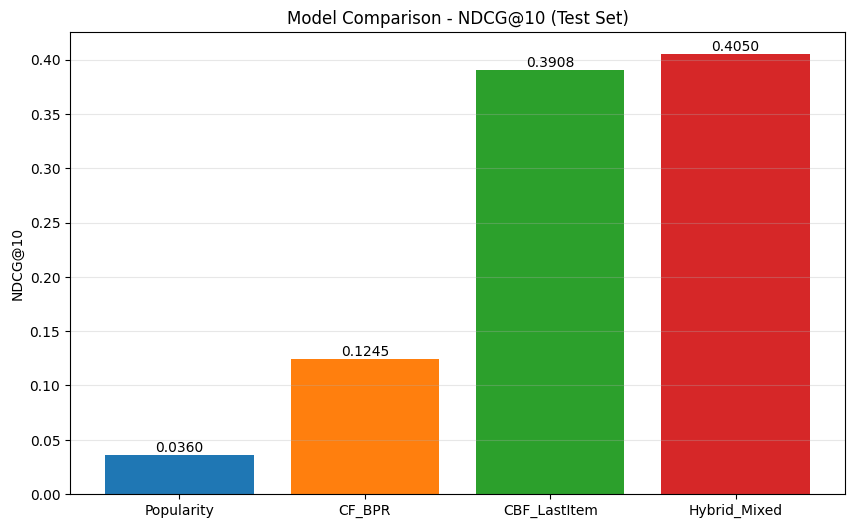

--- Performance Curves on test ---


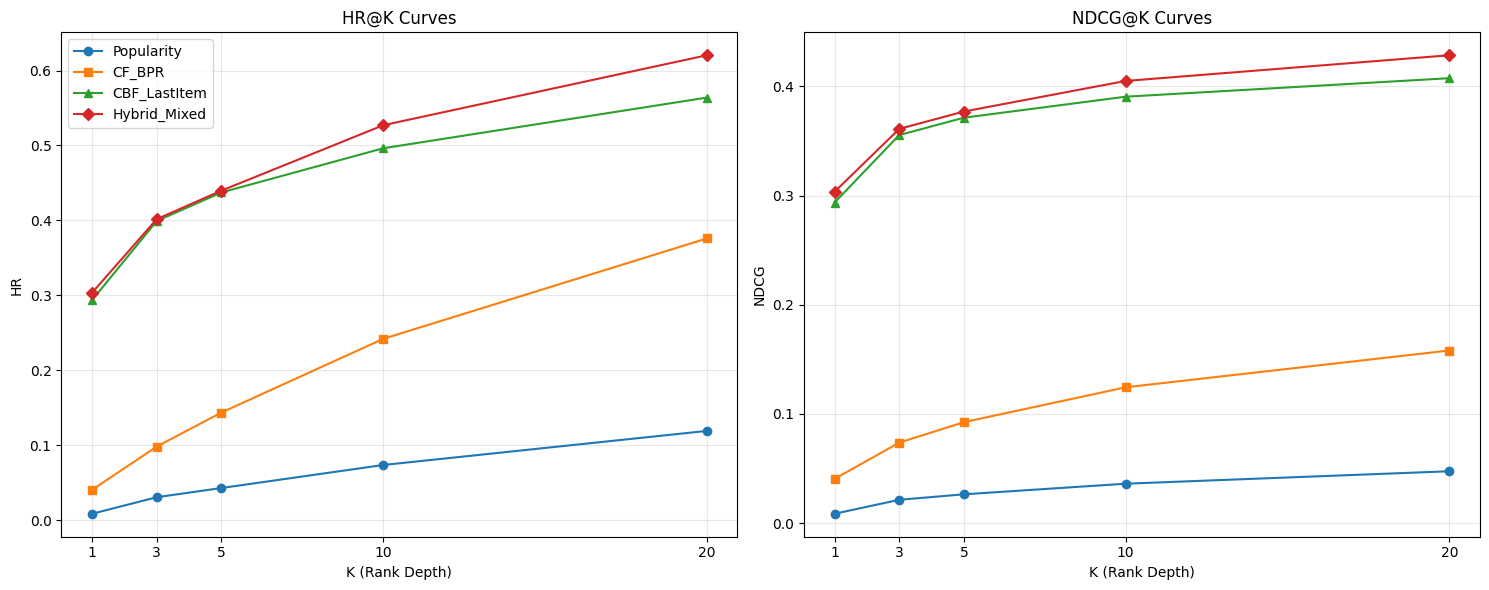

In [15]:
# 5. Visualizations

def plot_metric_comparison(results_df, metric="NDCG@10"):
    """Bar chart comparing models on a specific metric"""
    subset = results_df[results_df["split"] == "test"]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(subset["model"], subset[metric], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    
    plt.title(f"Model Comparison - {metric} (Test Set)")
    plt.ylabel(metric)
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom')
    plt.show()

def plot_performance_curves(split_name="test", k_values=[1, 3, 5, 10, 20], cf_w=0.3, cbf_w=0.7):
    """Line chart showing metrics at different K levels"""
    print(f"--- Performance Curves on {split_name} ---")
    
    # Load data
    candidates_df = pd.read_parquet(DATA_PROCESSED / f"eval_candidates_{split_name}.parquet")
    if split_name == "val":
        hist_df = train_df
    else:
        hist_df = pd.concat([train_df, val_df])
    user_history_map = hist_df.sort_values("ts_last").groupby("u")["i"].apply(list).to_dict()
    
    models = ["Popularity", "CF_BPR", "CBF_LastItem", "Hybrid_Mixed"]
    
    n_users = len(candidates_df)
    batch_size = 100
    
    # Accumulators: model -> metric -> k -> sum
    metrics_sum = {
        model: {
            "NDCG": {k: 0.0 for k in k_values},
            "HR": {k: 0.0 for k in k_values}
        } for model in models
    }
    
    for start in range(0, n_users, batch_size):
        end = min(start + batch_size, n_users)
        batch_df = candidates_df.iloc[start:end]
        batch_u = batch_df["u"].values
        batch_pos = batch_df["pos_i"].values
        batch_negs = np.stack(batch_df["neg_i"].values)
        candidates = np.column_stack([batch_pos, batch_negs])
        
        # Scores
        s_pop = score_popularity_candidates(candidates)
        s_cf = score_cf_candidates(batch_u, candidates)
        s_cbf = score_cbf_candidates(batch_u, candidates, user_history_map)
        s_hybrid = score_hybrid_candidates(s_cf, s_cbf, cf_weight=cf_w, cbf_weight=cbf_w)
        
        model_scores = {
            "Popularity": s_pop, "CF_BPR": s_cf, 
            "CBF_LastItem": s_cbf, "Hybrid_Mixed": s_hybrid
        }
        
        for m_name, scores in model_scores.items():
            # Compute metrics for all K values
            batch_res = eval_hr_ndcg(scores, ks=tuple(k_values), pos_col=0, rng=rng)
            for k in k_values:
                metrics_sum[m_name]["HR"][k] += batch_res[f"HR@{k}"] * len(batch_u)
                metrics_sum[m_name]["NDCG"][k] += batch_res[f"NDCG@{k}"] * len(batch_u)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    markers = ['o', 's', '^', 'D']
    
    for i, metric_type in enumerate(["HR", "NDCG"]):
        ax = axes[i]
        for j, model in enumerate(models):
            y_values = [metrics_sum[model][metric_type][k] / n_users for k in k_values]
            ax.plot(k_values, y_values, marker=markers[j], label=model)
        
        ax.set_xlabel("K (Rank Depth)")
        ax.set_ylabel(metric_type)
        ax.set_title(f"{metric_type}@K Curves")
        ax.set_xticks(k_values)
        ax.grid(True, alpha=0.3)
        if i == 0: ax.legend()
        
    plt.tight_layout()
    plt.show()

# Execute Visualizations
plot_metric_comparison(all_res, "NDCG@10")
plot_performance_curves("test", cf_w=best_cf_w, cbf_w=best_cbf_w)

### Statistical Significance Testing

In [ ]:
from scipy import stats
import metrics
import importlib
importlib.reload(metrics)
from metrics import get_user_metrics

def run_statistical_significance(split_name="test", cf_w=0.3, cbf_w=0.7):
    print(f"--- Statistical Significance Testing ({split_name}) ---")
    
    # Load Data & History
    candidates_df = pd.read_parquet(DATA_PROCESSED / f"eval_candidates_{split_name}.parquet")
    if split_name == "val":
        hist_df = train_df
    else:
        hist_df = pd.concat([train_df, val_df])
    user_history_map = hist_df.sort_values("ts_last").groupby("u")["i"].apply(list).to_dict()
    
    n_users = len(candidates_df)
    batch_size = 100
    
    # Storage for raw metrics
    raw_metrics = {
        "Hybrid_Mixed": {"NDCG": [], "HR": []},
        "CBF_LastItem": {"NDCG": [], "HR": []}
    }
    
    # Compute Scores & Metrics per User
    for start in range(0, n_users, batch_size):
        end = min(start + batch_size, n_users)
        batch_df = candidates_df.iloc[start:end]
        
        batch_u = batch_df["u"].values
        batch_pos = batch_df["pos_i"].values
        batch_negs = np.stack(batch_df["neg_i"].values)
        candidates = np.column_stack([batch_pos, batch_negs])
        
        # Scores
        s_cf = score_cf_candidates(batch_u, candidates)
        s_cbf = score_cbf_candidates(batch_u, candidates, user_history_map)
        s_hybrid = score_hybrid_candidates(s_cf, s_cbf, cf_weight=cf_w, cbf_weight=cbf_w)
        
        # Get Raw Metrics (Hybrid)
        m_hybrid = get_user_metrics(s_hybrid, k=10, pos_col=0, rng=rng)
        raw_metrics["Hybrid_Mixed"]["NDCG"].extend(m_hybrid["NDCG"])
        raw_metrics["Hybrid_Mixed"]["HR"].extend(m_hybrid["HR"])
        
        # Get Raw Metrics (CBF)
        m_cbf = get_user_metrics(s_cbf, k=10, pos_col=0, rng=rng)
        raw_metrics["CBF_LastItem"]["NDCG"].extend(m_cbf["NDCG"])
        raw_metrics["CBF_LastItem"]["HR"].extend(m_cbf["HR"])
        
    # Convert to arrays
    for model in raw_metrics:
        for m in raw_metrics[model]:
            raw_metrics[model][m] = np.array(raw_metrics[model][m])

    # Bootstrap Confidence Intervals
    def bootstrap_ci(data, n_boot=1000, ci=95):
        means = []
        for _ in range(n_boot):
            sample = rng.choice(data, size=len(data), replace=True)
            means.append(sample.mean())
        lower = np.percentile(means, (100-ci)/2)
        upper = np.percentile(means, 100 - (100-ci)/2)
        return lower, upper

    print("95% Confidence Intervals (Bootstrap n=1000):")
    for model in raw_metrics:
        ndcg_data = raw_metrics[model]["NDCG"]
        mean = ndcg_data.mean()
        low, high = bootstrap_ci(ndcg_data)
        print(f"{model:15s} | NDCG@10: {mean:.4f} [CI: {low:.4f}, {high:.4f}]")

    # Paired T-Test
    print("Paired T-Test (Hybrid vs CBF):")
    
    # NDCG
    h_ndcg = raw_metrics["Hybrid_Mixed"]["NDCG"]
    c_ndcg = raw_metrics["CBF_LastItem"]["NDCG"]
    t_stat, p_val = stats.ttest_rel(h_ndcg, c_ndcg)
    sig = "*" if p_val < 0.05 else "ns"
    print(f"NDCG@10: t={t_stat:.4f}, p={p_val:.4e} ({sig})")
    
    # HR
    h_hr = raw_metrics["Hybrid_Mixed"]["HR"]
    c_hr = raw_metrics["CBF_LastItem"]["HR"]
    t_stat, p_val = stats.ttest_rel(h_hr, c_hr)
    sig = "*" if p_val < 0.05 else "ns"
    print(f"HR@10:   t={t_stat:.4f}, p={p_val:.4e} ({sig})")

# Run Analysis
run_statistical_significance("test", cf_w=best_cf_w, cbf_w=best_cbf_w)

--- Statistical Significance Testing (test) ---
95% Confidence Intervals (Bootstrap n=1000):
Hybrid_Mixed    | NDCG@10: 0.4050 [CI: 0.3760, 0.4348]
CBF_LastItem    | NDCG@10: 0.3912 [CI: 0.3636, 0.4212]
Paired T-Test (Hybrid vs CBF):
NDCG@10: t=2.8201, p=4.9185e-03 (*)
HR@10:   t=2.6015, p=9.4492e-03 (*)
